# Simple R-matrix calculation

R-matrix methods

Created on Fri Feb  9 10:16:47 2018

@author: Y.-H.Song

basic unit are MeV. 

In [4]:
import numpy
import numpy as np 
import matplotlib.pyplot as plt
import mpmath  # for Coulomb functions
import sympy
import scipy

import numpy
import numpy as np

import matplotlib.pyplot as plt

import scipy 
import scipy.special
from scipy.special import factorial

from sympy.physics.sho import E_nl
from sympy import symbols
from sympy.physics.sho import R_nl
from sympy import var
from sympy.physics.wigner import wigner_9j
from sympy.physics.wigner import wigner_6j
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import clebsch_gordan

from functools import lru_cache


hbarc =197.3269788 # MeV.fm
alpha_em =1./137.035999 # fine structure constrant
                        # or alpha_em=e^2=1.44 MeV.fm  
amu = 931.4940954 # MeV/c^2 
mpi = 138.03898   # MeV/c^2 isoscalar pion mass 
conls=2.00   # hbar^2/(mpi^2 c^2) ~ 2.043 fm^2 for average pion  
mp  = 938.272    
mn  = 939.5653
mN = (mp+mn)/2.0 # isosclar nucleon mass

amu = 931.4940954 # MeV
mass_p  = 938.272    
mass_n  = 939.5653
mass_N = (mass_p+mass_n)/2.0
alpha = 1.0/137.03599

mass_alpha = 3727.4 # MeV 

fm = 1/hbarc # MeV^-1 

## Routines for Basis functions

basis_sine

basis_Gaussian

basis_Gaussian_I

basis_Lagrange



In [5]:
def basis_sine(r,i,a):
    """
    phi_i(r)=sin((pi*r/a)*(i-0.5))
    with r in (0,a)
    """
    return numpy.sin(numpy.pi*r/a*(i-0.5)) 

def basis_Gaussian(r,l,i,b1,x0):
    """
    phi_i(r)=r^(l+1)*exp(-(r/bi)^2)
    bi=b1*x0**(i-1)
    
    index i=1,2,... 
    """
    bi=b1*x0**(i-1)
    xx=(r/bi)**2        
    return r**(l+1)*numpy.exp(-xx)

def basis_Gaussian_I(k,nu,ch_radius=7.0):
    """
    eq.(C3) 
    note that channel radius 'a' is implied 
    """
    a=ch_radius
    kk=(k+1)*0.5 # (k+1)/2
    numer=( scipy.special.gamma(kk)
          *scipy.special.gammainc(kk,nu*a**2) )
    denom=2.0*nu**kk
    return numer/denom

def basis_Lagrange(orderN,indexi,r,ch_radius,weights=None,pointsx=None):
    """ return Lagrange function value at r
        (4.7) of Rep.Prog.Phys.73(2010)036301
        
        phi_i(r) 
        
        note indexi=1,2,...
        
        weights and pointsx are for Gauss-Legendre quadrature
        in (0,1) range.                
    """
    if (indexi < 1) or (orderN < 1 ):
        raise ValueError('Lagrange function index or order is wrong')
    # if weight and xi are given 
    if pointsx and weights:
        # check order 
        if (orderN != len(pointsx)) : 
            raise ValueError('Lagrange function order N mismatch')
            return
    else: # points xi is not given have to compute
        pointsx, weights=leggau(0.,1.,orderN)
    # compute Legendre Polynomial 
    xi=pointsx[indexi-1] 
    wi=weights[indexi-1]
    
    #---in casse at mesh points
    if abs(r-ch_radius*xi) < 1.0e-16 : # i=j case
        result= 1.0/np.sqrt(ch_radius*wi)
    else:
        PN_val=scipy.special.lpn(orderN,2*r/ch_radius-1.0)[0][orderN]   
        result=(-1)**(orderN+indexi)*(r/ch_radius/xi)*(
           np.sqrt(ch_radius*xi*(1-xi))*PN_val/(r-ch_radius*xi)) 
    
    return result

## Required subroutines 

(1) leggau : Legendre quadrature points and weights 

(2) Coulomb related functions 
    


In [6]:
def leggau(rmin,rmax,degree):
  """ get quadradure points and weights
  """  
  import numpy.polynomial.legendre as lg
  x , w = lg.leggauss(degree) # in range (-1,1) 
  x = (rmax+rmin)/2.+x*(rmax-rmin)/2.
  w = (rmax-rmin)/2.*w
  return x, w

In [40]:
def Coulomb_eta(charge_product,reduced_mass,pcm):
    """
        eta = Z1*Z2*alpha_em*(reduced_mass)/p 
    """
    return charge_product*alpha*(reduced_mass)/pcm 


def coulomb_phase_shift(l,eta):
    """
    Coulomb phase shift sigma_l(eta)
    """
    z=scipy.special.gamma(l+1+1j*eta)
    return numpy.angle(z)
  
def Coulomb_phaseshift(L,eta):
    return np.angle(scipy.special.gamma(L+1+1j*eta))

def Coulomb_factor(L,eta):
    """
    Gamow-Sommerfeld factor C_l(eta)**2
    """
    return np.exp(-np.pi*eta)*scipy.special.gamma(L+1+1j*eta)*scipy.special.gamma(L+1-1j*eta)

def Coulomb_norm_factor(L,eta):
    """
    normalization factor C_L(eta) eq.33.2.5 of NIST book
    """
    C_L = 2**L*np.exp(-np.pi*eta*0.5)/factorial(2*L+1)*np.abs(scipy.special.gamma(L+1+1j*eta))
    return C_L[0]

def Coulomb_h_l(L,eta,pcm):
    """
    h_l(eta)
    
    Note : not well defined numerically at eta =0.
    """
    temp=pcm**(2*L)*Coulomb_factor(L,eta)/Coulomb_factor(0,eta)
    out =temp*(scipy.special.digamma(1j*eta)+1./(2*1j*eta)-np.log(1j*eta))
    return out 

def Coulomb_scattering_amplitude(theta,eta,kcm):
    """
    Coulomb scattering amplitude for spin-less particle
    """
    temp1 = -eta/(2*kcm*np.sin(theta/2.0)**2)
    temp2 = np.exp(-1j*eta*np.log(np.sin(theta/2.0)**2)+2*1j* Coulomb_phaseshift(0,eta)   )
    return temp1*temp2

def coulomb_scat_amp(theta,eta,kmom):
    """
    Rutherford scattering amplitude
    
    theta in radian
    """
    sin_value=numpy.sin(0.5*theta)
    exponent=coulomb_phase_shift(0,eta)-eta*numpy.log(sin_value)
    scatt_amp=-eta/(2.0*kmom*sin_value**2)*numpy.exp(2.0*1j*exponent)
    return scatt_amp

def coulomb_dsda(theta,eta,kmom):
    """
    Rutherford differential cross section 
    """
    sin_value=numpy.sin(0.5*theta)
    return eta**2/(4.0*kmom**2*sin_value**4)

## Asymptotic Coulomb wave for R-matrix calculation

hard_sphere_phase

Shift-Penn 

__Unfortunately, the only available implementation of complex hypergeometric function or Coulomb functions are from mpmath package.   It can be slow.
  Scipy cannot handle complex parameters.__

In [41]:

def hard_sphere_phase(l,k,a,eta):
    """
      return hard sphere phase shift in radian
      
      phi_l(k)=-arctan(F_l(eta,ka)/G_l(eta,ka))
      
      k in MeV
      a in fm
    """
    z=k*a/hbarc
    Fl=mpmath.fp.coulombf(l,eta,z)
    Gl=mpmath.fp.coulombg(l,eta,z)
    return -numpy.arctan2(Fl,Gl)


def plot_shift_penn_factor(l,Z1=0,Z2=0,plot=False):
    """
    Plot S_l and P_l as a function of 
     E in hbar^2/(2mu a^2) units
     k a =sqrt( E in hbar^2/(2mu a^2) units )
     Thus 
     S_l(0,z) and P_l(0,z) with z=sqrt(E')
     
     in case of charged, choose a=aB. so that
     eta=sgn(Z1*Z2)/(k aB)=sgn(Z1*Z2)/ z.
     
    """
    ens=numpy.arange(0.01,2,0.05)
    ks=numpy.sqrt(ens)
    etas=numpy.sign(Z1*Z2)/ks
    Sls=numpy.zeros(len(ens))
    Pls=numpy.zeros(len(ens))
    for i in range(len(ens)):
        en=ens[i]        
        eta=etas[i]
        z=numpy.sqrt(en)
        
        Flx = lambda x: mpmath.coulombf(l,eta,x)
        Glx = lambda x: mpmath.coulombg(l,eta,x)
    
        Fl = Flx(z)
        Gl = Glx(z)
        Flp = mpmath.diff(Flx,z)
        Glp = mpmath.diff(Glx,z)
        
        Pl=z/(Fl**2+Gl**2)
        Sl=Pl*(Fl*Flp+Gl*Glp)
        
        Sl=sympy.sympify(Sl)
        Pl=sympy.sympify(Pl)
        Sls[i]=Sl
        Pls[i]=Pl
    if plot:    
        plt.subplot(211)    
        plt.plot(ens,Pls)    
        plt.xlabel('E')
        plt.ylabel('Pl(E)')
        plt.subplot(212)
        plt.plot(ens,Sls)
        plt.xlabel('E')
        plt.ylabel('Sl(E)')
    return ens,Sls,Pls    
    
def shift_penn_factor(l,eta,z):
    """
     compute
     Shift factor S_l(k) and
     Pennetration factor P_l(k)
     
     l = orbital angular momentum
     eta = Sommerfeld parameter
     z = k*a dimensionless     
     
     CAUTION: that the derivative over energy
     requires derivative of eta 
     as well as z!!
    """    
    Flx = lambda x: mpmath.coulombf(l,eta,x)
    Glx = lambda x: mpmath.coulombg(l,eta,x)
            
    Fl = Flx(z)
    Gl = Glx(z)
    
    Flp =  mpmath.diff(Flx,z)
    Glp =  mpmath.diff(Glx,z)
  
    Ol=Gl+1j*Fl
    Olp=Glp+1j*Flp
          
    Ll=z*Olp/Ol
        
    Sl=sympy.sympify(Ll.real)
    Pl=sympy.sympify(Ll.imag)
        
    return (Sl,Pl)

def shift_penn_dfactors(l,en,mu,z1z2,ch_radius,dE=0.0001) :
    """
      compute S_l(E), P_l(E)
      and S'_l(E) and P'_l(E)
      numerically
      
      en: MeV
      mu: MeV
      z1z2: product of zharge
      ch_radius: fm 
    """
    k0=numpy.sqrt(2.0*mu*en)
    eta0=z1z2*alpha_em*mu/k0
    z0=k0*ch_radius/hbarc
    
    k1=numpy.sqrt(2.0*mu*(en-dE))
    eta1=z1z2*alpha_em*mu/k1
    z1=k1*ch_radius/hbarc
    
    k2=numpy.sqrt(2.0*mu*(en+dE))
    eta2=z1z2*alpha_em*mu/k2
    z2=k2*ch_radius/hbarc
        
    (Sl,Pl)=shift_penn_factor(l,eta0,z0)
    (Sl1,Pl1)=shift_penn_factor(l,eta1,z1)
    (Sl2,Pl2)=shift_penn_factor(l,eta2,z2)
    
    Slp=(Sl2-Sl1)/(2.0*dE)
    Plp=(Pl2-Pl1)/(2.0*dE)
    
    return (float(Sl),float(Pl),float(Slp),float(Plp))

def Coulomb_functions(L,eta,rho):
    """
    Coulomb functions 
    F_L(eta,rho), G_L(eta,rho), H_L^+(eta,rho) and H_L^-(eta,rho)
    defined in NIST book eq.(33.2.8) and (33.2.11)
    
    G_l, H_l's are irregular at rho = 0. 
    
    Unfortunately, scipy hypergeometric functions can only take real parameters. 
    Thus, it cannot be used to define Coulomb functions...
    
    """
    sigma_L = coulomb_phase_shift(L,eta)
    theta_L = rho-eta*np.log(2*rho)-0.5*np.pi*L+sigma_L 
    if (rho > 0):
        Hplus_L = np.exp(1j*theta_L)*(-2*1j*rho)**(L+1+1j*eta)*scipy.special.hyperu(L+1+1j*eta,2*L+2, -2*1j*rho)
        Hmins_L = np.conjugate(Hplus_L)
        G_L     = np.real(Hplus_L)
        F_L     = np.imag(Hplus_L)
    else: 
        Hplus_L = None
        Hmins_L = None
        G_L     = None
        F_L     = Coulomb_norm_factor(L,eta)*rho**(L+1)*np.exp(-1j*rho)*scipy.special.hyp1f1(L+1-1j*eta, 2*L+2, 2*1j*rho)
    return (F_L, G_L, Hplus_L, Hmins_L)



In [45]:
scipy.special.hyperu(np.array([2+1+1j*1.0]),np.array([2*2+2]), np.array([-2*1j*1.5]))

TypeError: ufunc 'hyperu' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [42]:
%timeit mpmath.coulombf(2,1.0,1.5), mpmath.coulombg(2,1.0,1.5)
%timeit Coulomb_functions(2,1.0,1.5)

3.18 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


TypeError: ufunc 'hyperu' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Phenomenological R-matrix in single pole approximation

In [25]:
def phen_R_single_pole(l=0,eR=0.42,gamR=0.032,
              ap=1.0073,zp=1.0,at=12.0,zt=6.0, 
              ch_radius=7.0,energies=numpy.arange(0.1,1.2,0.01)):
    """
    phenomenological R-matrix calculation
    assume : there is only one resonance in one partial wave
                      (eR,GamR)
             if eR=None, return hard-sphere phase shift         
             range of Ecm energy.             
    return energies and phase shifts for l 
    
    """ 
    mu=ap*at/(ap+at)*mN #MeV
    if eR: #eR is given              
       (Sl,Pl,Slp,Plp)=shift_penn_dfactors(l,eR,mu,zp*zt,
                    ch_radius)
       gam_obs_sq=gamR/(2.0*Pl)
    # use Thomas approximations
       gam1_sq=gam_obs_sq/(1.-gam_obs_sq*Slp)
       E1=eR+gam1_sq*Sl
    # R-matrix
    ens=energies
    phases=numpy.zeros(len(ens))
    for i in range(len(ens)):
        en=ens[i]        
        Rl=gam1_sq/(E1-en)
        k=numpy.sqrt(2.0*mu*en)
        eta=zp*zt*alpha_em*mu/k
        phil=hard_sphere_phase(l,k,ch_radius,eta)
        (Sl,Pl,Slp,Plp)=shift_penn_dfactors(l,en,mu,zp*zt,
                    ch_radius)        
        phases[i]=phil+numpy.arctan2(Pl*Rl,(1.0-Sl*Rl))   
        #while phases[i] < -0.01 :
        #    phases[i]=phases[i]+numpy.pi             
    return ens,phases


# An example of R-matrix result of 12C+p case

Assume we already know resonance $E_R=0.42$ and $\Gamma_R=0.032$ for channel 1+ (L=0) of 12C+p elastic scattering.

Then, phen_R_single_pole gives phase shifts (in radian) 


Text(0, 0.5, 'degree')

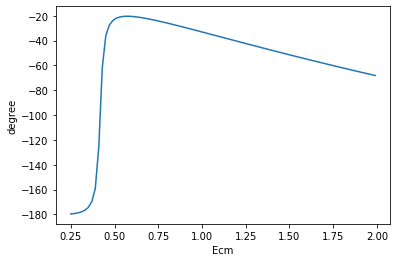

In [28]:
ecms, phas0 = phen_R_single_pole(l=0,eR=0.42,gamR=0.032,
              ap=1.0073,zp=1.0,at=12.0,zt=6.0, 
              ch_radius=7.0,energies=numpy.arange(0.25,2.0,0.02))
plt.plot(ecms,phas0*180/np.pi)
plt.xlabel('Ecm')
plt.ylabel('degree')

l=1 channel Er=1.558  Gamma=0.055

Text(0, 0.5, 'degree')

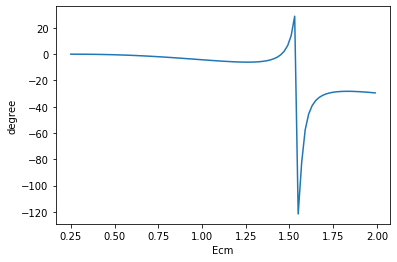

In [29]:
ecms, phas1 = phen_R_single_pole(l=1,eR=1.558,gamR=0.055,
              ap=1.0073,zp=1.0,at=12.0,zt=6.0, 
              ch_radius=7.0,energies=numpy.arange(0.25,2.0,0.02))
plt.plot(ecms,phas1*180/np.pi)
plt.xlabel('Ecm')
plt.ylabel('degree')

## cross section

If we only consider the case with only 1+ channel resonance (l=0) of 12C+p ,

the cross section becomes simply,

$ \frac{d\sigma}{d\Omega}(\theta,E) = |f_c(\theta)+e^{2i\sigma_0}(\frac{e^{2i \delta_0}-1}{2ik})|^2$

In fact, one can add more resonances and use hard-sphere phaseshift for other partial waves.

However, using zero phase shift for non-resonance gives almost the same results. 
Also, only one partial wave l=0 seems to be good enough at low energy 

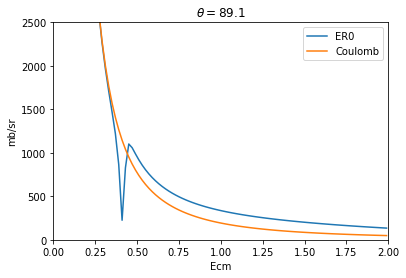

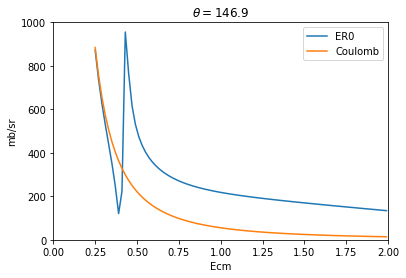

In [31]:
ap=1.0073; zp=1.0 ; at=12.0 ; zt=6.0 ;
mu = ap*at/(ap+at)*mN ;
kcm = np.sqrt(2*mu*ecms)
etas = Coulomb_eta(6.0,mu,kcm)

#-----theta=89.1 case
theta = 89.1 ; #degree
f_cs = Coulomb_scattering_amplitude(theta*np.pi/180,etas,kcm)*hbarc # need to convert in fm units
sigma0s=Coulomb_phaseshift(0,etas)
sigma1s=Coulomb_phaseshift(1,etas)
f_ls = np.exp(2*1j*sigma0s)*(np.exp(2*1j*phas0)-1.0)/(2*1j*kcm)*hbarc # need to convert in fm units 
diff_cross = np.abs(f_cs+f_ls)**2
diff_cross_Coulomb = np.abs(f_cs)**2
plt.figure()
plt.plot(ecms,diff_cross*10,label='ER0')
plt.plot(ecms,diff_cross_Coulomb*10,label='Coulomb')
plt.xlim([0,2]);
plt.ylim([0,2500]);
plt.title(r'$\theta=$89.1')
plt.xlabel('Ecm')
plt.ylabel('mb/sr')
plt.legend()

#-----theta=146.9 case
theta = 146.9 ; #degree
f_cs = Coulomb_scattering_amplitude(theta*np.pi/180,etas,kcm)*hbarc # need to convert in fm units
sigma0s=Coulomb_phaseshift(0,etas)
f_ls = np.exp(2*1j*sigma0s)*(np.exp(2*1j*phas0)-1.0)/(2*1j*kcm)*hbarc # need to convert in fm units 
diff_cross = np.abs(f_cs+f_ls)**2
diff_cross_Coulomb = np.abs(f_cs)**2
plt.figure()
plt.plot(ecms,diff_cross*10,label='ER0')
plt.plot(ecms,diff_cross_Coulomb*10,label='Coulomb')
plt.xlim([0,2]);
plt.ylim([0,1000]);
plt.title(r'$\theta=$146.9')
plt.xlabel('Ecm');
plt.ylabel('mb/sr');
plt.legend()

## test of calculable R-matrix method

We may solve the 12C+p scattering using optical potential and 
solve the problem in calculable R-matrix method

In [13]:
def test_pot1(r):
    """
    eq. (4.14) potential for 12C+p
    """    
    vn=-73.8*numpy.exp(-(r/2.70)**2)
    vc=6.0*alpha_em/r*hbarc
    return vn+vc
    

In [21]:
def test_cal_R(basis_N=15 , b1=1.4, x0=0.6,    ch_radius=8.0,    
    l=0,
    ap=1.0,zp=1.0,
    at=12.0,zt=6.0,ens=numpy.arange(0.05,2.0,0.01) ):
    """
      l=0 12C+p scattering calculation in R-matrix method
      
      using Gaussian basis
      
      However, the results in Table 1 and fig 4
      is not reproduced correctly yet..
    """

    bi=numpy.array([b1*x0**i for i in range(basis_N)  ] ) # Gaussian para
    # note that the index starts from 1 in eq.(4.6) and eq.(4.5)
    # need to check following code for index !!
    mu=ap*at/(ap+at)*mN
    
    #---Gauassian potential
    v0_g=-73.8 # MeV
    r0_g=2.70 # fm 
#------special case    
#    mu  = 1.0
#    v0_g=-1.0 # MeV
#    r0_g= 1.0 # fm 
#    zp=1.0
#    zt=0.0 
#    hbarc=1.0
#    ens=numpy.array([0.1,1.0,10.0])
    phases=numpy.zeros(len(ens))
    for ei in range(len(ens)):
      en=ens[ei]  
      kmom=numpy.sqrt(2.0*mu*en) # MeV
      eta=zp*zt*alpha_em*mu/kmom
      #---construct Cij in eq.(3.14)  
      
      TLij=numpy.zeros((basis_N,basis_N))  # Tl+L(0) term
      Vcij=numpy.zeros((basis_N,basis_N))  # Coulomb term
      VNij=numpy.zeros((basis_N,basis_N))  # Nuclear pot term     
      Eij =numpy.zeros((basis_N,basis_N))  # constant energy term     
      Cij =numpy.zeros((basis_N,basis_N))  # C-mat  
      nus = 1.0/bi**2  # 
      
      for i in range(basis_N):
          nui= nus[i]
          for j in range(i,basis_N):
             nuj= nus[j]  
             TLij[i,j]= hbarc**2/(2*mu)*( 4.0*nui*nuj
             #TLij[i,j]= ( 4.0*nui*nuj    
                   *basis_Gaussian_I(2*l+4,nui+nuj,ch_radius=ch_radius)
                   -2.0*(l+1)*(nui+nuj)
                   *basis_Gaussian_I(2*l+2,nui+nuj,ch_radius=ch_radius)
                   +(l+1)*(2*l+1)
                   *basis_Gaussian_I(2*l,nui+nuj,ch_radius=ch_radius) )             
             Vcij[i,j]=zp*zt*alpha_em*hbarc*basis_Gaussian_I(2*l+1,nui+nuj
                                    ,ch_radius=ch_radius)
             VNij[i,j]=v0_g*basis_Gaussian_I(2*l+2,nui+nuj+1.0/r0_g**2
                                   ,ch_radius=ch_radius)
             Eij[i,j] =en*basis_Gaussian_I(2*l+2,nui+nuj
                                   ,ch_radius=ch_radius) 
             Cij[i,j]=TLij[i,j]+Vcij[i,j]+VNij[i,j]-Eij[i,j]  
             Cij[j,i]=Cij[i,j] #symmetry 
      # -- done construting Cij, now compute inverse C
      Cinv=scipy.linalg.inv(Cij)
      fac1=hbarc**2/(2*mu*ch_radius) # eq(3.15)
      sums=0.0
      for i in range(basis_N):
          for j in range(basis_N):
              sums= ( sums+ 
                     Cinv[i,j]*basis_Gaussian(ch_radius,l,i+1,b1,x0)
                              *basis_Gaussian(ch_radius,l,j+1,b1,x0) )
      Rl=fac1*sums # R-matrix eq.(3.15)
      phil=hard_sphere_phase(l,kmom,ch_radius,eta)
      (Sl,Pl,Slp,Plp)=shift_penn_dfactors(l,en,mu,zp*zt,
                    ch_radius)        
      phase = phil+numpy.arctan2(Pl*Rl,(1.0-Sl*Rl))   
      while phase < -0.01 :
            phase = phase +numpy.pi

      phases[ei]=phase
        
    return ens,phases*180./np.pi

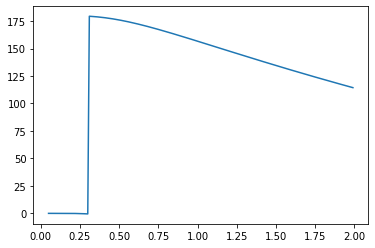

In [23]:
ens,phs = test_cal_R()
plt.plot(ens,phs)